© Alexander Jüstel, Fraunhofer IEG, Institution for Energy Infrastructures and Geothermal Systems, RWTH Aachen University,
GNU Lesser General Public License v3.0

# 15 Calculating Heat Demand Density along Street segments

This notebook illustrates how to calculate the heat demand density along street segments. Here the heat demand of the adjacent buildings will attributed to the closest street segment (LineString).

## Importing Libraries

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely

from pyheatdemand import processing

C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Loading Heat Demand Data

The heat demand data utilized here can be downloaded from https://www.opengeodata.nrw.de/produkte/umwelt_klima/klima/raumwaermebedarfsmodell/.

In [2]:
buildings = gpd.read_file('../../../../../Downloads/Notebooks/Aachen_Buildings.shp').drop('id', axis=1)
footprints = buildings.copy(deep=True)
buildings['geometry'] = buildings.centroid
buildings = buildings[buildings['WB_HU']>0].reset_index(drop=True)
buildings.head()

,WB_HU,geometry
0,768.012128,POINT (292705.144 5627871.339)
1,1010.052042,POINT (292705.613 5627867.064)
2,849.072467,POINT (292429.547 5627523.452)
3,454.138112,POINT (292561.555 5627797.114)
4,2335.658552,POINT (292403.666 5627494.653)


## Loading Street Segments

The street segments were downloaded from OpenStreet Maps and were edited for the purpose of this tutorial.

In [3]:
roads = gpd.read_file('../../../../../Downloads/Notebooks/Aachen_Streets.shp').to_crs('EPSG:25832')
roads.head()

,full_id,osm_id,osm_type,highway,bicycle,service,zone_traff,turn_lanes,source_max,ref,...,name_etymo,oneway,foot,width,surface,sidewalk,name,maxspeed,lit,geometry
0,w5155813,5155813,way,residential,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7,asphalt,both,Hanbrucher Straße,30,yes,"LINESTRING (292758.350 5627929.657, 292768.884..."
1,w5215882,5215882,way,residential,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,no,yes,NaN,asphalt,both,Am Neuenhof,30,yes,"LINESTRING (292687.050 5627901.427, 292681.924..."
2,w12077876,12077876,way,residential,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Am Backes,30,yes,"LINESTRING (292300.152 5627645.147, 292300.800..."
3,w12078449,12078449,way,residential,NaN,NaN,NaN,NaN,NaN,NaN,...,Q66190,NaN,NaN,NaN,asphalt,NaN,Leo-Blech-Straße,30,yes,"LINESTRING (292341.172 5627706.044, 292313.565..."
4,w12078450,12078450,way,residential,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,asphalt,NaN,Nekesstraße,30,NaN,"LINESTRING (292383.174 5627774.798, 292335.277..."


## Plotting the data

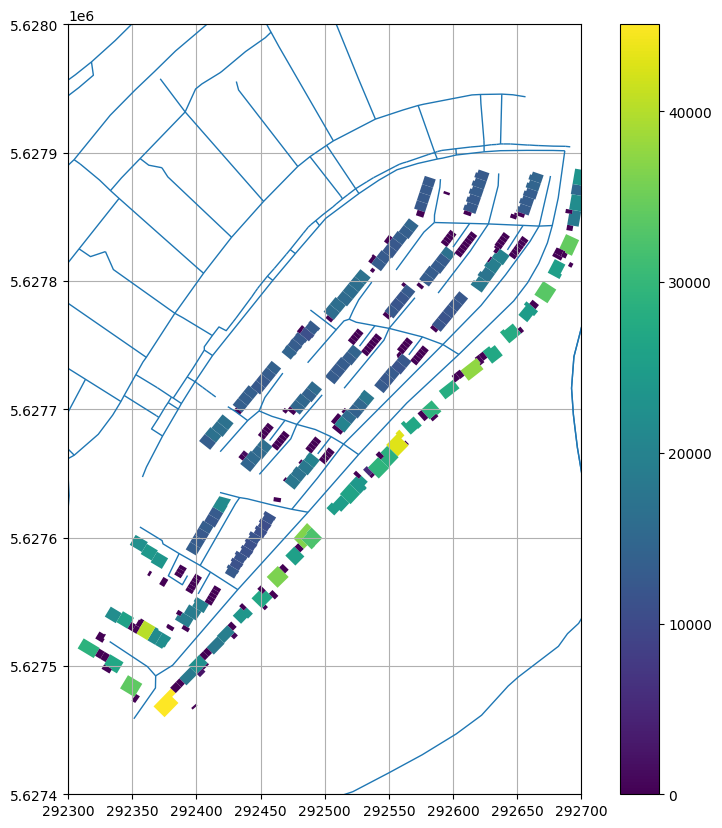

In [4]:
fig, ax = plt.subplots(1, figsize=(10,10))

footprints.plot(ax=ax, column='WB_HU', markersize=1, legend=True)
roads.plot(ax=ax, linewidth=1)
ax.set_xlim(292300, 292700)
ax.set_ylim(5627400,5628000)
plt.grid()

## Creating Connections

The connection between every house and the nearest road is created using `create_connections(..)`.

In [5]:
gdf_connections = processing.create_connections(gdf_buildings=buildings,
                                                gdf_roads=roads,
                                                hd_data_column='WB_HU')
gdf_connections

C:\Users\ale93371\Anaconda3\envs\pygeomechanical\lib\site-packages\shapely\linear.py:90: RuntimeWarning: invalid value encountered in line_locate_point
  return lib.line_locate_point(line, other)


,geometry,WB_HU
0,"LINESTRING (292726.502 5627866.823, 292705.144...",768.012128
1,"LINESTRING (292725.657 5627862.826, 292705.613...",1010.052042
2,"LINESTRING (292726.502 5627866.823, 292705.144...",768.012128
3,"LINESTRING (292725.657 5627862.826, 292705.613...",1010.052042
4,"LINESTRING (292413.265 5627537.473, 292429.547...",849.072467
...,...,...
153,"LINESTRING (292421.857 5627634.247, 292419.748...",21470.730216
154,"LINESTRING (292458.715 5627625.513, 292456.294...",11794.683169
155,"LINESTRING (292565.484 5627742.419, 292561.759...",12185.490605
156,"LINESTRING (292599.944 5627826.338, 292596.116...",16881.994814


## Plotting the data

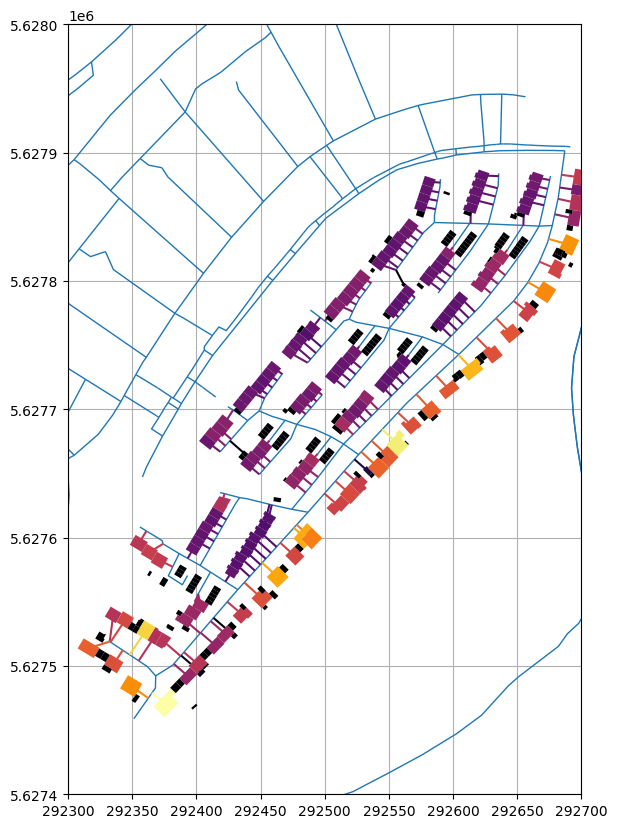

In [6]:
fig, ax = plt.subplots(1, figsize=(10,10))

# Roads
roads.plot(ax=ax, linewidth=1)

# Connections between houses and roads
gdf_connections.plot(ax=ax, column='WB_HU', cmap='inferno')

# Houses
footprints.plot(ax=ax, column='WB_HU', cmap='inferno', zorder=100)

ax.set_xlim(292300, 292700)
ax.set_ylim(5627400,5628000)
plt.grid()

## Calculating the Heat Demand for each Street segment

The heat demand of every house is attributed to the nearest street segment using `calculate_hd_street_segments(..)`.

In [9]:
gdf_hd = processing.calculate_hd_street_segments(gdf_buildings=buildings,
                                                gdf_roads=roads,
                                                hd_data_column='WB_HU')
gdf_hd.head()

,WB_HU,full_id,osm_id,osm_type,highway,bicycle,service,zone_traff,turn_lanes,source_max,...,oneway,foot,width,surface,sidewalk,name,maxspeed,lit,geometry,HD_normalized
1,923948.221657,w5215882,5215882,way,residential,NaN,NaN,NaN,NaN,NaN,...,no,yes,NaN,asphalt,both,Am Neuenhof,30,yes,"LINESTRING (292687.050 5627901.427, 292681.924...",1741.960760
8,25628.624084,w13745756,13745756,way,residential,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Pieter-Bruegel-Straße,30,yes,"LINESTRING (292677.282 5627843.170, 292667.040...",278.830764
11,72448.930662,w13745760,13745760,way,residential,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,asphalt,NaN,Jean-Lejeune-Straße,30,NaN,"LINESTRING (292432.216 5627559.482, 292410.911...",793.926439
15,1778.064170,w38532829,38532829,way,path,designated,NaN,NaN,NaN,NaN,...,yes,designated,NaN,asphalt,NaN,NaN,NaN,NaN,"LINESTRING (292760.238 5628176.202, 292771.633...",3.223262
22,38124.672958,w201078988,201078988,way,service,NaN,driveway,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (292410.911 5627573.158, 292401.356...",1952.001877


## Plotting the data

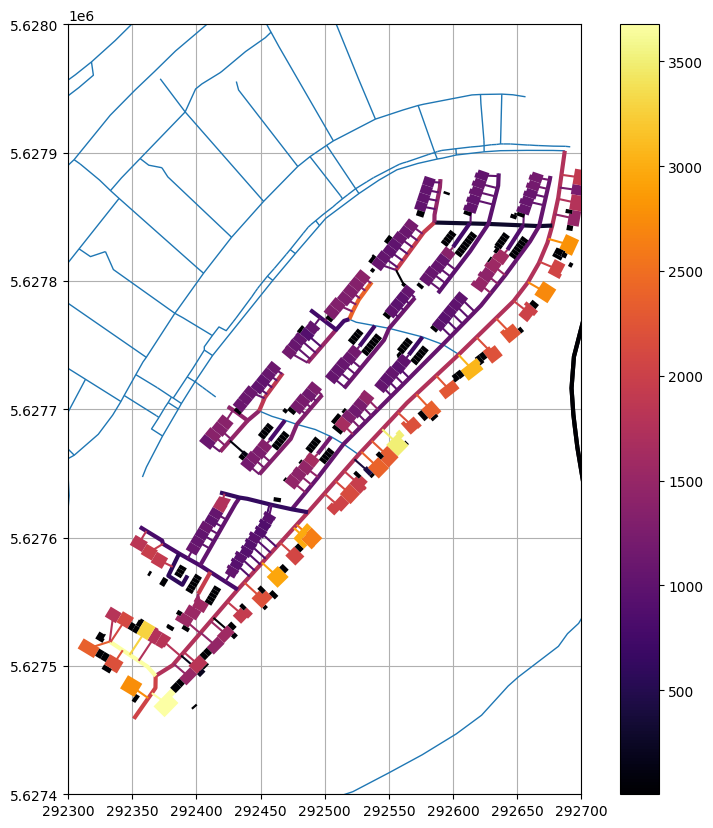

In [16]:
fig, ax = plt.subplots(1, figsize=(10,10))

# Roads
roads.plot(ax=ax, linewidth=1)
gdf_hd.plot(ax=ax, column='HD_normalized', cmap='inferno', linewidth=3, legend=True)


# Connections between houses and roads
gdf_connections.plot(ax=ax, column='WB_HU', cmap='inferno')

# Houses
footprints.plot(ax=ax, column='WB_HU', cmap='inferno', zorder=100)

ax.set_xlim(292300, 292700)
ax.set_ylim(5627400,5628000)
plt.grid()